In [27]:
import os, sys
sys.path.append(os.path.abspath(".."))  # so notebooks can import src

from src.eda import (
    plot_class_distribution, plot_histogram, plot_box_by_class, plot_fraud_rate_by_category
)

from src.preprocessing import (
    clean_dataset, add_time_features, add_behavior_features,
    ip_to_country_merge, prepare_X_y, one_hot_encode, scale_numeric,
    drop_non_numeric_and_ids
)


In [28]:
import pandas as pd


In [29]:
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip = pd.read_csv("../data/raw/IpAddress_to_Country.csv")


In [30]:
fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [31]:
fraud.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [32]:
fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])


In [33]:
fraud.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [34]:
fraud.duplicated().sum()


np.int64(0)

In [35]:
fraud = fraud.drop_duplicates()


In [36]:
fraud["class"].value_counts()


class
0    136961
1     14151
Name: count, dtype: int64

In [37]:
fraud["class"].value_counts(normalize=True)


class
0    0.906354
1    0.093646
Name: proportion, dtype: float64

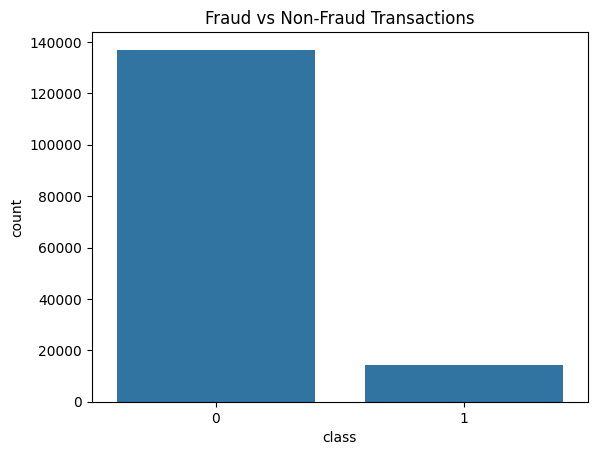

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="class", data=fraud)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()


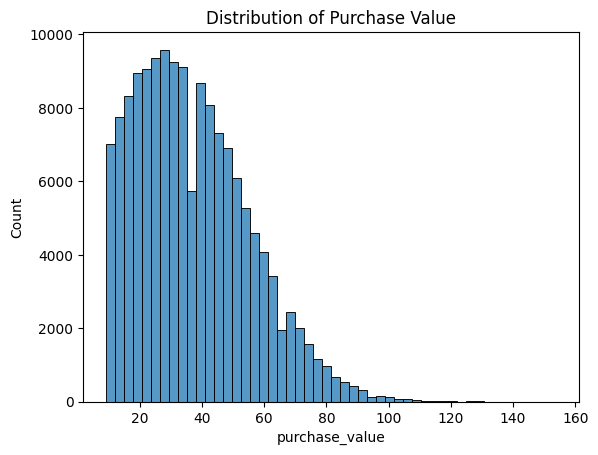

In [39]:
sns.histplot(fraud["purchase_value"], bins=50)
plt.title("Distribution of Purchase Value")
plt.show()


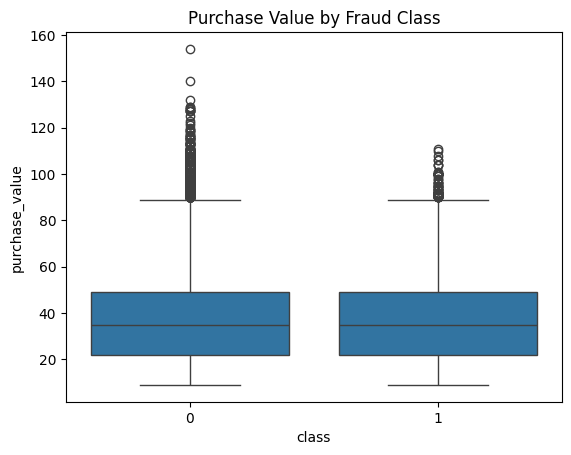

In [40]:
sns.boxplot(x="class", y="purchase_value", data=fraud)
plt.title("Purchase Value by Fraud Class")
plt.show()


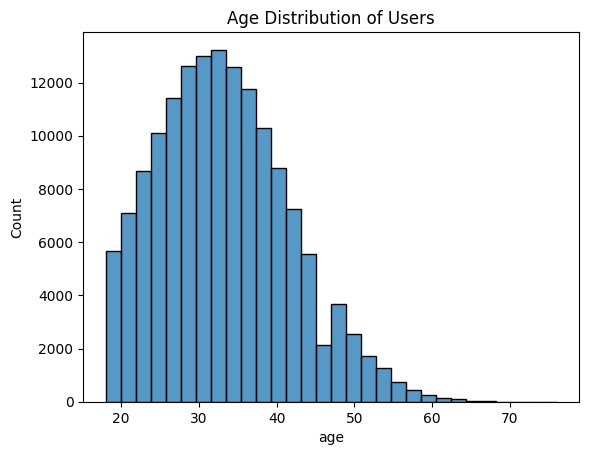

In [41]:
sns.histplot(fraud["age"], bins=30)
plt.title("Age Distribution of Users")
plt.show()


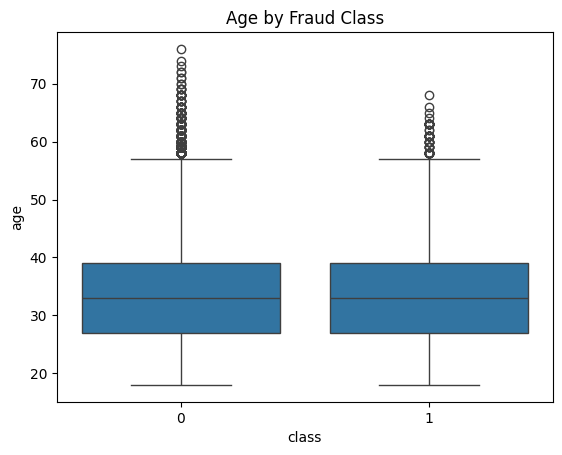

In [42]:
sns.boxplot(x="class", y="age", data=fraud)
plt.title("Age by Fraud Class")
plt.show()


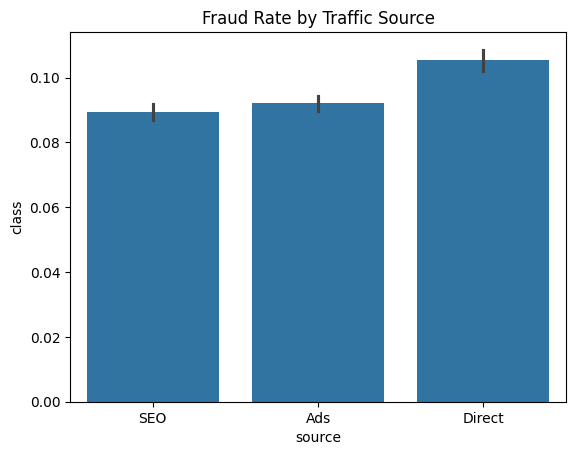

In [43]:
sns.barplot(
    x="source",
    y="class",
    data=fraud,
    estimator=lambda x: sum(x) / len(x)
)
plt.title("Fraud Rate by Traffic Source")
plt.show()


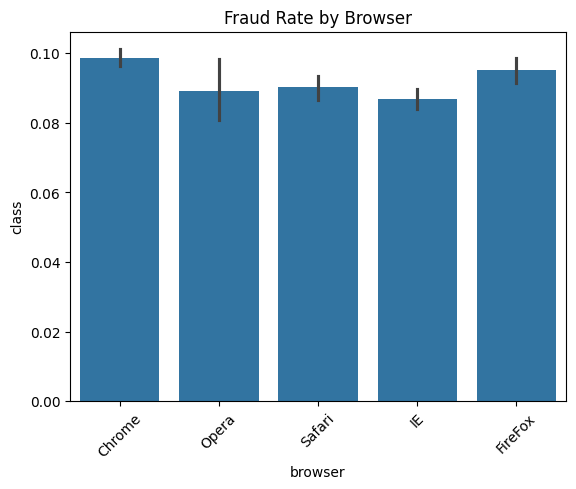

In [44]:
sns.barplot(
    x="browser",
    y="class",
    data=fraud,
    estimator=lambda x: sum(x) / len(x)
)
plt.title("Fraud Rate by Browser")
plt.xticks(rotation=45)
plt.show()


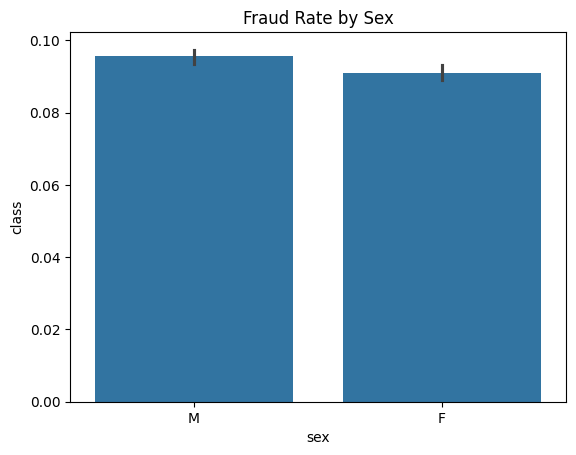

In [45]:
sns.barplot(
    x="sex",
    y="class",
    data=fraud,
    estimator=lambda x: sum(x) / len(x)
)
plt.title("Fraud Rate by Sex")
plt.show()


In [46]:
ip.head()


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [47]:
fraud["ip_address"] = fraud["ip_address"].astype("int64")

ip["lower_bound_ip_address"] = ip["lower_bound_ip_address"].astype("int64")
ip["upper_bound_ip_address"] = ip["upper_bound_ip_address"].astype("int64")


In [48]:
fraud = fraud.sort_values("ip_address")
ip = ip.sort_values("lower_bound_ip_address")


In [49]:
fraud = pd.merge_asof(
    fraud,
    ip,
    left_on="ip_address",
    right_on="lower_bound_ip_address",
    direction="backward"
)

# keep only valid IP ranges
fraud = fraud[fraud["ip_address"] <= fraud["upper_bound_ip_address"]]


In [50]:
fraud[["ip_address", "country"]].head()


,ip_address,country
634,16778864,Australia
635,16842045,Thailand
636,16843656,China
637,16938732,China
638,16971984,Thailand


In [51]:
fraud.groupby("country")["class"].mean().sort_values(ascending=False).head()


country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Name: class, dtype: float64

In [52]:
fraud["hour_of_day"] = fraud["purchase_time"].dt.hour
fraud["day_of_week"] = fraud["purchase_time"].dt.dayofweek


In [53]:
fraud["time_since_signup"] = (
    fraud["purchase_time"] - fraud["signup_time"]
).dt.total_seconds()


In [54]:
fraud["txn_count_user"] = fraud.groupby("user_id")["user_id"].transform("count")


In [55]:
fraud[[
    "hour_of_day",
    "day_of_week",
    "time_since_signup",
    "txn_count_user"
]].head()


,hour_of_day,day_of_week,time_since_signup,txn_count_user
634,3,6,3632215.0,1
635,20,2,1231637.0,1
636,23,5,1997534.0,1
637,16,5,7640897.0,1
638,4,1,10249579.0,1


In [56]:
y = fraud["class"]
X = fraud.drop(columns=["class", "signup_time", "purchase_time"])


In [57]:
X = pd.get_dummies(
    X,
    columns=["source", "browser", "sex", "country"],
    drop_first=True
)


In [58]:
from sklearn.preprocessing import StandardScaler

num_cols = [
    "purchase_value",
    "age",
    "time_since_signup",
    "txn_count_user"
]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


In [59]:
X.head()


,user_id,purchase_value,device_id,age,ip_address,lower_bound_ip_address,upper_bound_ip_address,hour_of_day,day_of_week,time_since_signup,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
634,247547,0.549607,KIXYSVCHIPQBR,-0.363124,16778864,16778240.0,16779263.0,3,6,-0.413800,...,False,False,False,False,False,False,False,False,False,False
635,220737,-1.197335,PKYOWQKWGJNJI,0.101168,16842045,16809984.0,16842751.0,20,2,-1.180852,...,False,False,False,False,False,False,False,False,False,False
636,390400,0.385831,LVCSXLISZHVUO,-0.479197,16843656,16843264.0,16843775.0,23,5,-0.936126,...,False,False,False,False,False,False,False,False,False,False
637,69592,0.986342,UHAUHNXXUADJE,-0.363124,16938732,16924672.0,16941055.0,16,5,0.867086,...,False,False,False,False,False,False,False,False,False,False
638,174987,0.767974,XPGPMOHIDRMGE,0.449387,16971984,16941056.0,16973823.0,4,1,1.700633,...,False,False,False,False,False,False,False,False,False,False


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [61]:
y_train.value_counts()


class
0    93502
1     9814
Name: count, dtype: int64

In [62]:
import pandas as pd
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")


In [63]:
fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])


In [64]:
y = fraud["class"]
X = fraud.drop(columns=["class", "signup_time", "purchase_time"])


In [65]:
X = pd.get_dummies(
    X,
    columns=["source", "browser", "sex", "country"],
    drop_first=True
)


KeyError: "['country'] not in index"

In [ ]:
X.columns


Index(['user_id', 'purchase_value', 'device_id', 'source', 'browser', 'sex',
       'age', 'ip_address'],
      dtype='object')

In [ ]:
ip = pd.read_csv("../data/raw/IpAddress_to_Country.csv")
ip.head()


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
# fraud ip (sometimes loads as float)
fraud["ip_address"] = fraud["ip_address"].astype("int64")

# ip range bounds
ip["lower_bound_ip_address"] = ip["lower_bound_ip_address"].astype("int64")
ip["upper_bound_ip_address"] = ip["upper_bound_ip_address"].astype("int64")


In [ ]:
fraud = fraud.sort_values("ip_address")
ip = ip.sort_values("lower_bound_ip_address")

fraud = pd.merge_asof(
    fraud,
    ip,
    left_on="ip_address",
    right_on="lower_bound_ip_address",
    direction="backward"
)

# keep only rows where ip_address is within the upper bound
fraud = fraud[fraud["ip_address"] <= fraud["upper_bound_ip_address"]]


In [ ]:
ip.columns


Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')

In [ ]:
ip.columns = ip.columns.str.strip()
fraud.columns = fraud.columns.str.strip()


In [ ]:
fraud = fraud.sort_values("ip_address")
ip = ip.sort_values("lower_bound_ip_address")

fraud = pd.merge_asof(
    fraud,
    ip,
    left_on="ip_address",
    right_on="lower_bound_ip_address",
    direction="backward"
)

fraud = fraud[fraud["ip_address"] <= fraud["upper_bound_ip_address"]]


In [ ]:
fraud[["ip_address", "country"]].head()


,ip_address,country
0,16778864,Australia
1,16842045,Thailand
2,16843656,China
3,16938732,China
4,16971984,Thailand


In [ ]:
y = fraud["class"]
X = fraud.drop(columns=["class", "signup_time", "purchase_time"])


In [ ]:
X = pd.get_dummies(
    X,
    columns=["source", "browser", "sex", "country"],
    drop_first=True
)


In [ ]:
fraud.columns


Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'lower_bound_ip_address_x', 'upper_bound_ip_address_x', 'country_x',
       'lower_bound_ip_address_y', 'upper_bound_ip_address_y', 'country_y',
       'lower_bound_ip_address', 'upper_bound_ip_address', 'country'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
y_train.value_counts()


class
0    93502
1     9814
Name: count, dtype: int64

In [ ]:
X_train.dtypes[X_train.dtypes == "object"]


device_id    object
country_x    object
country_y    object
dtype: object

In [ ]:
cols_to_drop = [
    "device_id",
    "ip_address",
    "lower_bound_ip_address",
    "upper_bound_ip_address",
    "lower_bound_ip_address_x",
    "upper_bound_ip_address_x",
    "lower_bound_ip_address_y",
    "upper_bound_ip_address_y",
    "country_x",
    "country_y"
]

X_train = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns])
X_test  = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns])


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
y_train_res.value_counts()


class
0    93502
1    93502
Name: count, dtype: int64

In [66]:
# fix country column BEFORE encoding
if "country" not in X.columns:
    if "country_y" in X.columns:
        X["country"] = X["country_y"]
    elif "country_x" in X.columns:
        X["country"] = X["country_x"]

# drop merge leftovers
X = X.drop(columns=[c for c in ["country_x", "country_y"] if c in X.columns], errors="ignore")


In [69]:

# make sure we only encode columns that actually exist
cat_cols = ["source", "browser", "sex", "country"]

# keep only the ones present in X
cat_cols = [c for c in cat_cols if c in X.columns]

print("Encoding these columns:", cat_cols)

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)



Encoding these columns: ['source', 'browser', 'sex']


In [70]:
[c for c in X.columns if "country" in c.lower()]


[]